In [2]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
from transformers import BertTokenizer


In [3]:
dataframes = []
for i in range(9):
    dataframes.append(pd.read_csv(f"data/trolls/IRAhandle_tweets_{i+1}.csv"))
trolldata = pd.concat(dataframes)

genuine = pd.read_csv("data/genuine/Political_tweets.csv")


C:\Users\Jayden\AppData\Local\Temp\ipykernel_15956\3022758360.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  genuine = pd.read_csv("data/genuine/Political_tweets.csv")


***Data Pre-Processing***

**Removing Non-English entries**

In [4]:
#Removing non-english entries
troll = trolldata[trolldata["language"] == "English"]
# genuine.iloc[:100_000]
troll

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36991,3.093874e+09,_YOUR_LIFESTYLE,Like me. Share me. Follow me http://t.co/VvhUO...,Unknown,English,10/8/2015 15:01,10/8/2015 15:01,59,13,458,NaN,Russian,0,0,NonEnglish
37053,3.093874e+09,_YOUR_LIFESTYLE,.the main thing is to was love https://t.co/oq...,Unknown,English,11/4/2015 8:24,11/4/2015 8:25,68,23,518,NaN,Russian,0,0,NonEnglish
37337,3.093874e+09,_YOUR_LIFESTYLE,Amazing! Found my script: Download ReBuild - W...,United States,English,6/25/2016 11:27,6/25/2016 11:28,40,40,817,NaN,Russian,0,0,NonEnglish
37410,3.093874e+09,_YOUR_LIFESTYLE,Present Perfect http://t.co/vNu3i2Xh4M,Unknown,English,7/31/2015 18:35,7/31/2015 18:36,59,4,305,NaN,Russian,0,0,NonEnglish


**Finding any instances of known troll authors in genuine dataset**

In [5]:
#Getting list of troll authors
trollauthors = []
for author in troll['author'].unique():
    trollauthors.append(author)
trollauthors

#Getting list of genuine authors
genuineauthors = genuine['user_name'].apply(lambda x: x.upper() if isinstance(x, str) else x)

#Searching for identical names

matches = []
for rname,tname in zip(genuineauthors,trollauthors):
    if rname == tname:
        matches.append(rname)

print(f"Found {len(matches)} matches: {matches}")



Found 0 matches: []


**Removal of unique metadata**<br>
We can't have any metadata that is strictly limited to one dataset. That will instantly cause bias.

I also removed information about the authors of the tweet.

In addition, column names have been changed to fit to the troll dataset

In [6]:
troll.drop(columns=["language","harvested_date","publish_date","external_author_id","following","account_type","new_june_2018","region","post_type","updates","account_category"],inplace=True)
troll.drop(columns=["author"],inplace=True)
genuine.drop(columns=['user_name','user_location','user_description','user_created','user_friends','user_favourites','user_verified','date','hashtags','source'],inplace=True)

namechanges = {
"user_followers":"followers",
"is_retweet":"retweet",
"text":"content",

}

genuine.rename(columns=namechanges,inplace=True)



C:\Users\Jayden\AppData\Local\Temp\ipykernel_15956\1357675685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  troll.drop(columns=["language","harvested_date","publish_date","external_author_id","following","account_type","new_june_2018","region","post_type","updates","account_category"],inplace=True)
C:\Users\Jayden\AppData\Local\Temp\ipykernel_15956\1357675685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  troll.drop(columns=["author"],inplace=True)


**Add labels to datasets and concatenate**

In [7]:
genuine['retweet'].unique()

array([False, nan], dtype=object)

In [8]:
genlabels = np.zeros(shape=(len(genuine),1))


trolabels = np.ones(shape=(len(troll),1))

genuine['troll'] = genlabels
troll['troll'] = trolabels
genuine['retweet'] = genuine['retweet'].apply(lambda x: 0 if x == False else 1)

bigdataset = pd.concat([genuine.reset_index(drop=True), troll.reset_index(drop=True)], axis=0)
bigdataset


C:\Users\Jayden\AppData\Local\Temp\ipykernel_15956\3308870631.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  troll['troll'] = trolabels


,followers,content,retweet,troll
0,711.0,US says seizes tanker used to evade North Kore...,0,0.0
1,3.0,Is America the greatest country? Part 1 drops ...,0,0.0
2,36219.0,O’Reilly predicts THIS is What DOOMS Biden’s r...,0,0.0
3,2426.0,Corruption in Politics\n#blog #politics \nhttp...,0,0.0
4,13763.0,@kylegriffin1 Are you getting all the info on ...,0,0.0
...,...,...,...,...
2128958,13.0,Like me. Share me. Follow me http://t.co/VvhUO...,0,1.0
2128959,23.0,.the main thing is to was love https://t.co/oq...,0,1.0
2128960,40.0,Amazing! Found my script: Download ReBuild - W...,0,1.0
2128961,4.0,Present Perfect http://t.co/vNu3i2Xh4M,0,1.0


In [9]:
bigdataset.isna().sum().sum()

1

**Normalization**
The only column that needs normalization at this stage is followers. So I min-max normalized it

In [10]:
x = bigdataset['followers']
def logscaling(x):
    scaled = np.log(x+1)
    return scaled

logscaled = logscaling(x).value_counts()

# plt.bar(logscaled.index,height=logscaled)
# plt.xlabel("Followers")
# plt.ylabel("Users")
# plt.title("Distribution of Followers (Log scaled)")
# plt.show()


#Normalizing Dataset
bigdataset['followers'] = logscaling(bigdataset['followers'])

In [11]:
"""
Minmax Scaling (not good for this specific distribution)

"""
# def minmax(iter:pd.Series):
#     mx = iter.max()
#     min = iter.min()
#     normalized = []
#     for val in iter:
#         normalized.append( (val - min)/mx-min)
#     return pd.Series(normalized)

# 4
# bigdataset['followers'] = minmax(bigdataset['followers'])
# bigdataset.reset_index(inplace=True)


'\nMinmax Scaling (not good for this specific distribution)\n\n'

**Preparation for Transformer input. Part 1**
I created two special tokens that help cut down the input length. 

*[LINK]* represents links and *[HASH]* represents hashtags

In [12]:

#Removes any instance of a non-string input. I decided this was better than just stringifying inputs because numerical inputs aren't useful.
bigdataset['content'] = bigdataset['content'].apply(lambda x: np.nan if type(x) != str else x )
bigdataset.dropna(inplace=True)

def preprocess_text(text):
    # Remove newline characters
    
    text = re.sub(r'\n+', ' ', text)
    # Replacing URLs
    text = re.sub(r'https?://\S+', '', text)
    # Replacing Hashtags
    text = re.sub(r'#\w+', '', text)
    return text.strip()

def counthash(text):
    num_hashtags = len(re.findall(r'#\w+', text))
    return num_hashtags
def countlinks(text):
    num_links = len(re.findall(r'https?://\S+', text))
    return num_links
#Applying function
bigdataset['hash'] = bigdataset['content'].apply(counthash)
bigdataset['link'] = bigdataset['content'].apply(counthash)
bigdataset['content'] = bigdataset['content'].apply(preprocess_text)

# bigdataset[]
bigdataset.reset_index(inplace=True,drop=True)


In [13]:
bigdataset['content'][0]

'US says seizes tanker used to evade North Korea sanctions'

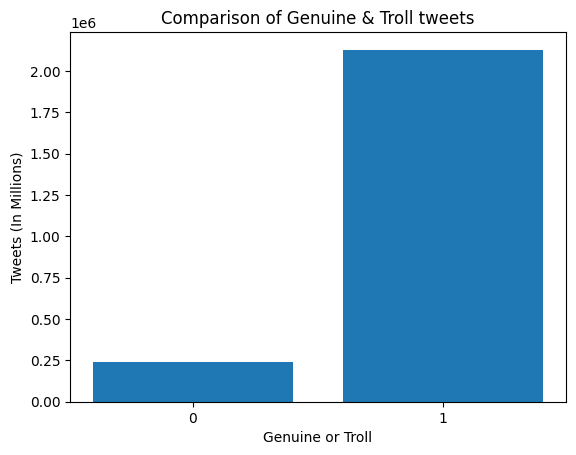

In [14]:
x= pd.to_numeric(bigdataset['troll'].value_counts(), downcast='integer')
plt.bar(x.index,x)
plt.xticks([0, 1])
plt.xlabel("Genuine or Troll")
plt.ylabel("Tweets (In Millions)")
plt.title("Comparison of Genuine & Troll tweets")
plt.show()

In [15]:


# def countHash(series):
#     count = 0
#     for item in series:
#         if '[HASH]' in item:
#             count +=1
#     return count

# def countURL(series):
#     count = 0
#     for item in series:
#         if '[LINK]' in item:
#             count +=1
#     return count

# def countCAPS(series,t=0):
#     count = 0
#     for item in series:
#         words = item.split()
#         if sum(1 for word in words if word.isupper()) > t:
#             count += 1
#     return count



# def pie(data:list,labels,title,func):
#     trollfunc,genfunc = func(data[0]),func(data[1])
#     plt.pie([trollfunc,genfunc],labels = labels,shadow=True)
#     plt.title(title)
#     plt.show()

# #Get 80% of the genuine tweets
# num_items = round(len(genuine) * 0.8)
# train = bigdataset.groupby('troll').sample(num_items,random_state=1)


# trolls = train.loc[train['troll'] == 1.0]['content']
# genuine = train.loc[train['troll'] == 0.0]['content']
# trollhash = countHash(trolls)
# genhash = countHash(genuine)


# pie([trolls,genuine],['Troll','Genuine'],"Proportions of Hashtags present in tweets",countHash)

# pie([trolls,genuine],['Troll','Genuine'],"Proportions of URLs present in tweets",countURL)

# pie([trolls,genuine],['Troll','Genuine'],"Proportions of Capital Words present in tweets",countCAPS)

# # train.plot(data="hash"kind='bar',)

# total = trollhash + genhash

# print(f"Troll hash percentage: {trollhash/total}")
# print(f"Genuine hash percentage: {genhash/total}")







# print(countCAPS(trolls)/len(trolls))


In [16]:
bigdataset.iloc[1336245]

followers    5.303305
content              
retweet             1
troll             1.0
hash                1
link                1
Name: 1336245, dtype: object

In [17]:
bigdataset.to_csv("data/transformed/data.csv")


bigdataset = pd.read_csv("data/transformed/data.csv")
bigdataset.dropna(inplace=True)
bigdataset.to_csv("data/transformed/data.csv")


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

text = bigdataset['content'][0]
# text = bigdataset['content'][0].apply(tokenizer.encode)
encoded_input = tokenizer.encode(text, add_special_tokens=True)
encoded_input

[101,
 1646,
 1867,
 16414,
 1116,
 24096,
 1215,
 1106,
 174,
 27923,
 1456,
 3577,
 19344,
 102]